### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [20]:
import json
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import random
import joblib
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [10]:
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

dataset = [generate_normal_data() for _ in range(1000)]

os.makedirs("dataset", exist_ok=True)
with open("dataset/training_data.json", "w") as f:
    json.dump(dataset, f, indent=2)

In [3]:
with open("dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
display(df)

,src_port,dst_port,packet_size,duration_ms,protocol
0,22,23328,1362,106,TCP
1,22,28080,1342,256,TCP
2,80,5104,1383,179,TCP
3,443,49468,712,418,UDP
4,443,22124,1072,217,TCP
...,...,...,...,...,...
995,80,39529,856,332,TCP
996,80,52224,1468,186,UDP
997,443,34261,601,428,TCP
998,80,46834,807,247,UDP


### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [4]:
def preprocess_data(df):
    #TODO 1: Implement preprocessing steps
    
    numeric_features = ['src_port', 'dst_port', 'packet_size', 'duration_ms']
    categorical_features = ['protocol']
    if not hasattr(preprocess_data, "preprocessor"):
        # Create and fit transformer first time
        preprocess_data.preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numeric_features),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
            ])
        preprocess_data.preprocessor.fit(df)
    
    X_transformed = preprocess_data.preprocessor.transform(df)
    return X_transformed
X = preprocess_data(df)
X

array([[2.2000e+01, 2.3328e+04, 1.3620e+03, 1.0600e+02, 1.0000e+00,
        0.0000e+00],
       [2.2000e+01, 2.8080e+04, 1.3420e+03, 2.5600e+02, 1.0000e+00,
        0.0000e+00],
       [8.0000e+01, 5.1040e+03, 1.3830e+03, 1.7900e+02, 1.0000e+00,
        0.0000e+00],
       ...,
       [4.4300e+02, 3.4261e+04, 6.0100e+02, 4.2800e+02, 1.0000e+00,
        0.0000e+00],
       [8.0000e+01, 4.6834e+04, 8.0700e+02, 2.4700e+02, 0.0000e+00,
        1.0000e+00],
       [8.0800e+03, 3.0714e+04, 9.0600e+02, 1.2800e+02, 0.0000e+00,
        1.0000e+00]])

### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [5]:
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(X)

IsolationForest(contamination=0.01, random_state=42)

### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [6]:
joblib.dump(model, "anomaly_model.joblib")

['anomaly_model.joblib']

In [9]:
def generate_anomalous_data():
    return {
        "src_port": random.randint(10000, 20000),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(10, 50),
        "duration_ms": random.randint(1000, 5000),
        "protocol": random.choice(["TCP", "UDP"])
    }

anomalies = [generate_anomalous_data() for _ in range(50)]
df_anomalies = pd.DataFrame(anomalies)
df_anomalies.head()

,src_port,dst_port,packet_size,duration_ms,protocol
0,14784,52504,15,2027,TCP
1,13854,9590,35,4965,UDP
2,13443,39703,47,1631,TCP
3,14304,1214,11,4509,TCP
4,11664,59912,50,4828,UDP


In [11]:
X_anomal = preprocess_data(df_anomalies)
X_anomal

array([[1.4784e+04, 5.2504e+04, 1.5000e+01, 2.0270e+03, 1.0000e+00,
        0.0000e+00],
       [1.3854e+04, 9.5900e+03, 3.5000e+01, 4.9650e+03, 0.0000e+00,
        1.0000e+00],
       [1.3443e+04, 3.9703e+04, 4.7000e+01, 1.6310e+03, 1.0000e+00,
        0.0000e+00],
       [1.4304e+04, 1.2140e+03, 1.1000e+01, 4.5090e+03, 1.0000e+00,
        0.0000e+00],
       [1.1664e+04, 5.9912e+04, 5.0000e+01, 4.8280e+03, 0.0000e+00,
        1.0000e+00],
       [1.3047e+04, 1.5399e+04, 1.1000e+01, 1.7390e+03, 1.0000e+00,
        0.0000e+00],
       [1.0916e+04, 2.4292e+04, 3.1000e+01, 4.1370e+03, 1.0000e+00,
        0.0000e+00],
       [1.3129e+04, 3.9537e+04, 1.7000e+01, 1.1500e+03, 0.0000e+00,
        1.0000e+00],
       [1.8736e+04, 6.4572e+04, 1.1000e+01, 2.6730e+03, 0.0000e+00,
        1.0000e+00],
       [1.7111e+04, 4.0553e+04, 3.0000e+01, 2.3400e+03, 1.0000e+00,
        0.0000e+00],
       [1.4726e+04, 5.1060e+03, 3.0000e+01, 4.6940e+03, 1.0000e+00,
        0.0000e+00],
       [1.3588e+04, 6

In [13]:
X_combined = np.vstack([X, X_anomal])
true_labels = np.array([0]*len(X) + [1]*len(X_anomal))  # 0=normal, 1=anomaly

# predict data

In [14]:
pred_labels = model.predict(X_combined)

# Convert to 0=normal, 1=anomaly for easier evaluation
pred_labels = np.where(pred_labels == 1, 0, 1)

In [16]:
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=["Normal", "Anomaly"]))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, pred_labels))

Classification Report:

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      1000
     Anomaly       0.83      1.00      0.91        50

    accuracy                           0.99      1050
   macro avg       0.92      0.99      0.95      1050
weighted avg       0.99      0.99      0.99      1050

Confusion Matrix:

[[990  10]
 [  0  50]]


# PCA for 2D Visualization

Text(0, 0.5, 'PCA Component 2')

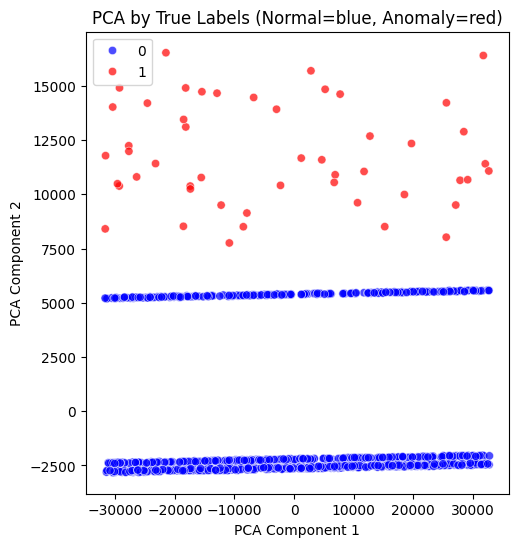

In [21]:
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X_combined)

plt.figure(figsize=(12,6))

# Plot true labels
plt.subplot(1,2,1)
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=true_labels,
                palette=['blue', 'red'], alpha=0.7)
plt.title("PCA by True Labels (Normal=blue, Anomaly=red)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Confidence Scoring Function

In [23]:
def score_new_samples(samples_df):
    
    X = preprocess_data(samples_df)
    decision_scores = model.decision_function(X)
    # Normalize scores to [0,1], higher means more normal
    conf_scores = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
    pred = model.predict(X)
    pred_labels = np.where(pred == 1, 0, 1)  # 0=normal,1=anomaly
    return pred_labels, conf_scores

example_df = pd.concat([df.sample(5), df_anomalies.sample(5)], ignore_index=True)
preds, confs = score_new_samples(example_df)
print("\nExample new sample predictions and confidence scores:")
print(pd.DataFrame({
    "prediction": preds,
    "confidence_score": confs
}))


Example new sample predictions and confidence scores:
   prediction  confidence_score
0           0          1.000000
1           0          0.903712
2           0          0.366380
3           0          0.954180
4           0          0.873284
5           1          0.000000
6           1          0.062607
7           1          0.095647
8           1          0.106210
9           1          0.174224
